<a href="https://colab.research.google.com/github/szsavery/DSPS_SSavery/blob/main/HW5/FitLineToGRBAfterGlow_mcmc_Savery_DSOS23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting a line to GRB afterglow photometry

This exercise teaches you to fit the simplest model to data: a line, using different methods.

Notes:

    a line is a power law in log-log space. The GRB afterglow is generated by a powerlaw process
    
    we will learn later that a broken powerlaw is a prefer model for the GRB afterglow. But this exercise is about fitting lines: Linear Regression
    

# initial imports

In [1]:
import pandas as pd
import pylab as pl
import numpy as np
%pylab inline



Populating the interactive namespace from numpy and matplotlib


# Read in the input dataset
I am reading the data with Pandas. Pandas has excellent utilities for input-output of tabular data and also for time variables. We will use it throughout as our main package to acquire and manipulate data

In [2]:
grbAG = pd.read_csv("https://raw.githubusercontent.com/fedhere/DSPS_FBianco/main/data/grb050525A.csv")
grbAG.head()

,filter,time,mag,magerr,upperlimit
0,V,66,13.21,0.24,0
1,V,67,12.90,0.23,0
2,V,68,12.86,0.23,0
3,V,69,13.01,0.23,0
4,V,70,12.97,0.23,0


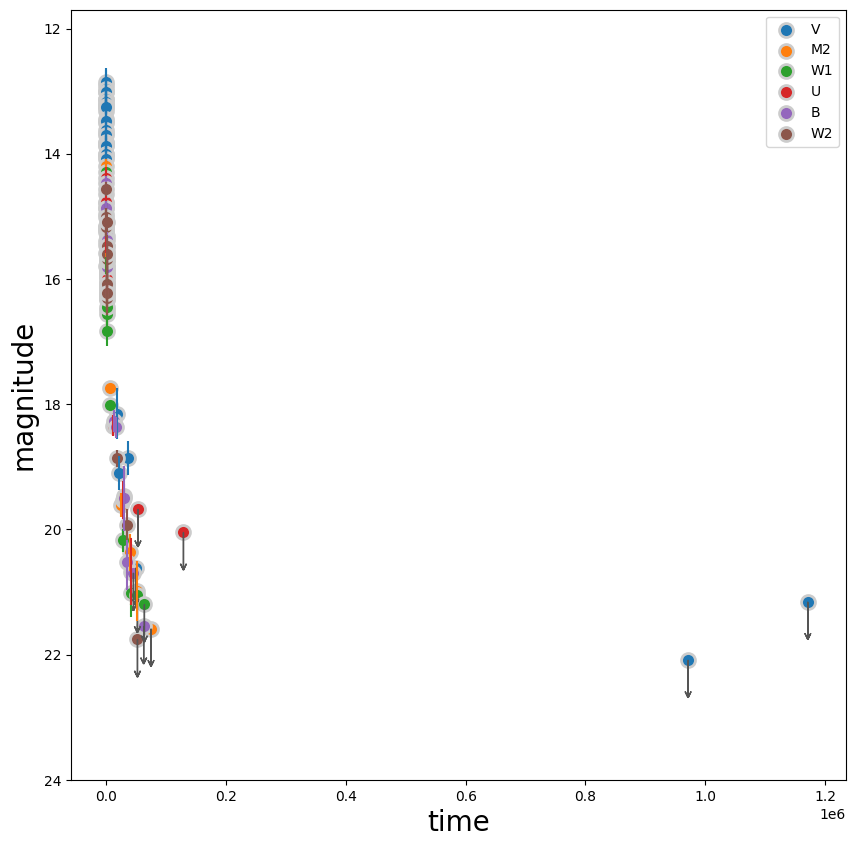

In [3]:
#create a figure container and an axis object inside of it
ax = pl.figure(figsize=(10,10)).add_subplot(111)

#loop on every filter to plot - this will give differnt colors naturally.
#Use pl.errorbar to plot the uncertainties

for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "time"],
                grbAG.loc[grbAG["filter"] == f, "mag"],
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"],
                fmt='.', ms=0,
                fcolor=None, label=None)

# replot to add a better marker (optional)
for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "time"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')


# plot the upperlimits as arrows
nuplim = grbAG.mag.isna().sum()
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].time,
             grbAG.loc[i].mag, 0, 0.5, head_width=1e4,
             overhang=1, shape="full",
             head_length=0.1, ec='#555555', visible=True)

# I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
pl.ylim(24,11.7)
pl.legend()

#Always rememebr you axis labels!!
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("time", fontsize=20);

###Figure 1

Basic plot of magnitude versus time. Highlights that the far right points are outliers also shows that time needs to be a log scale.

# Create the log-time variable

We will fit a line in log space. That corresponds to fitting a powerlaw y=x^a in natural space.


In [4]:
#Code from previous work
grbAG['logtime'] = np.log10(grbAG['time'])

grbAG.head()

,filter,time,mag,magerr,upperlimit,logtime
0,V,66,13.21,0.24,0,1.819544
1,V,67,12.90,0.23,0,1.826075
2,V,68,12.86,0.23,0,1.832509
3,V,69,13.01,0.23,0,1.838849
4,V,70,12.97,0.23,0,1.845098


# Visualize the data
The data are photometric measurements: measurement of flux from an exploding star. The flux is measured in different photometric bands, i.e. within different wavelength range. You can think about this as a filter that would limit the light collected by a camera to a single color, e.g. red, blue, or green. In most all cameras (your phone camera for example) collect data in RGB bands saparately and combine them to create a "color picture". Our eyes also perceive color in 3 bands, R, G, B.

The information about the photometric band is stored in the variable ```grbAG.filter```. Plot the data with different colors for different photometric bands.

In [5]:
def plotlogtime(df, models=[]):
  #create a figure container and an axis object inside of it
  ax = pl.figure(figsize=(10,10)).add_subplot(111)

  #loop on every filter to plot - this will give differnt colors naturally.
  #Use pl.errorbar to plot the uncertainties

  for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "logtime"],
                grbAG.loc[grbAG["filter"] == f, "mag"],
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"],
                fmt='.', ms=0,
                fcolor=None, label=None)

  # replot to add a better marker (optional)
  for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "logtime"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')


  # plot the upperlimits as arrows
  nuplim = grbAG.mag.isna().sum()
  for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime,
             grbAG.loc[i].mag, 0, 0.5, head_width=0.1,
             overhang=1, shape="full",
             head_length=0.1, ec='#555555', visible=True)

  # I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
  pl.ylim(24,11.7)
  pl.legend()

  #Always rememebr you axis labels!!
  pl.ylabel("magnitude", fontsize=20)
  pl.xlabel("log time", fontsize=20)
  return ax

<Axes: xlabel='log time', ylabel='magnitude'>

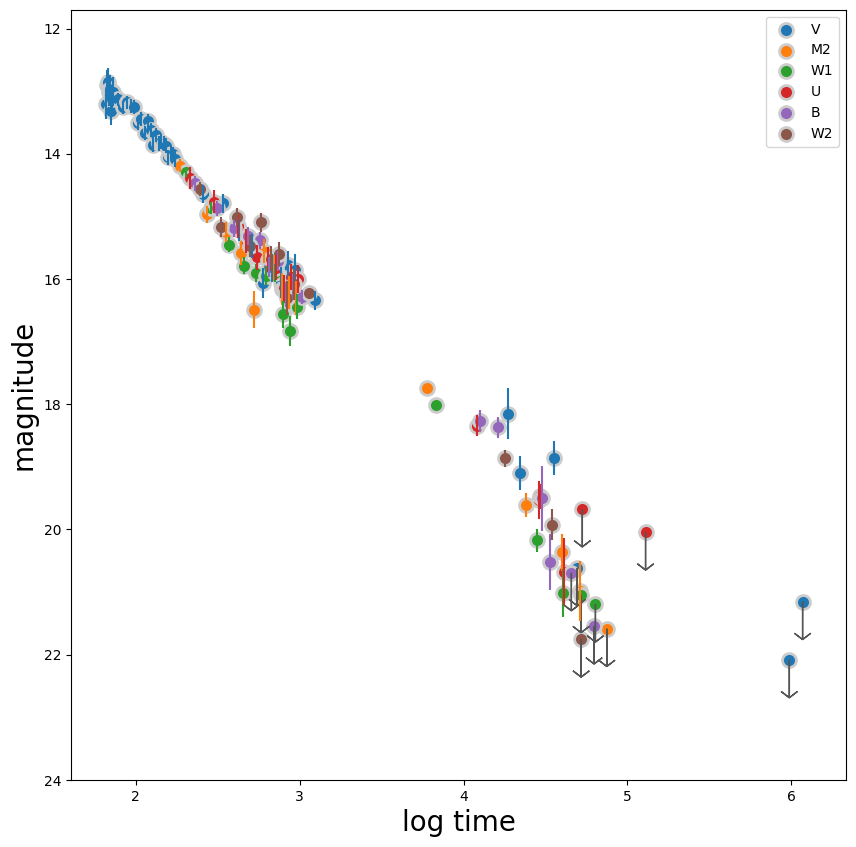

In [6]:
plotlogtime(grbAG)

Figure 2: Photometry of the Afterglow of GRB 052505A. All photometry is from the Swift satellite and it is obtained from Table 3 of Blustin et al. 2005 https://arxiv.org/pdf/astro-ph/0507515.pdf. The photometric band for each datapoint is indicated in the legend. Time is relative from the estimated moment of explosion of the stellar progenitor. Upperlimits are indicated by down-pointing arrows.

# Solve using the Normal Equation

It can be shown that the best linear fit to data is given by the equation:  

$(X^T \cdot X)^{-1} \cdot X^T \cdot \vec{y}$

The solution is a tuple of 2 parameters: sloper and intercept. Therefore the input has to be Nx2


In [7]:
x = grbAG[grbAG.upperlimit == 0].logtime.values
X = np.c_[np.ones((len(grbAG) - grbAG.upperlimit.sum(), 1)),
          x]


y = grbAG.loc[grbAG.upperlimit == 0].mag.values
print("shape of the input array X", X.shape)
print("shape of the input array y", y.shape)
#note the shape in python is flipped compared to the shape in linear algebra

shape of the input array X (108, 2)
shape of the input array y (108,)


In [8]:
theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
print ("best fit parameters from the Normal Equation: " +
       "intercept {:.2f}, slope {:.2f}".format(*theta_best))

best fit parameters from the Normal Equation: intercept 8.58, slope 2.51


# Fit a line to the data (excluding the upper limits) with sklearn LinearRegression

The exogenous (independent) variable is ```grbAG.logtime```.

The information about whether the point is an upper limit or a measurement is stored in the variable ```grbAG.upperlimit```.
To remove the upper limits you can "broadcast" the data: in pandas that looks like

```grbAG.loc[grbAG.upperlimit == 0]```



In [9]:
#note: imports should be moved to the top cell - follow PEP8 guidelines
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

#Code from previous work
lr.fit(X, y)

lr.intercept_

8.582668233648771

# Fit a line to the data (excluding the upper limits) by minimizing an objective function

First, choose the L1 and L2 metric (see class notes) as the objective function.

Use ```scipy.optimize.minimize()``` to minimize it.


In [10]:
def line(intercept, slope, x):
    return intercept+ slope*x

In [11]:
#note: imports should be moved to the top cell - follow PEP8 guidelines
from scipy.optimize import minimize

def l1(args, x, y):
  ''' l1 target function returns value of l1 for the given arguments and data
    args are model parameters
    x: the exogenous variable (array)
    y: the exogenous variable (array)
    returns the absolute value of the difference between a linear function and y
  '''
  intercept, slope = args
  total = np.sum(np.abs(line(intercept, slope, x) - y))
  return total


initialGuess = (10, 1)

l1Solution = minimize(l1, initialGuess, args=(x, y))
print(l1Solution)
print("")
print("best fit parameters from the minimization of L1: " +
       "slope {:.2f}, intercept {:.2f}".format(*l1Solution.x))

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 26.303317772383874
        x: [ 8.225e+00  2.641e+00]
      nit: 17
      jac: [-1.359e-01 -2.094e+00]
 hess_inv: [[ 1.935e-04 -4.675e-05]
            [-4.675e-05  1.132e-05]]
     nfev: 391
     njev: 125

best fit parameters from the minimization of L1: slope 8.23, intercept 2.64


In [12]:

def l2(args, x, y):
    '''l2 target function: returns value of l2 for given arguments and data for a line model
    arg: (array) model arguments (parameters)
    x: the exogenous variable (array)
    y: the exogenous variable (array)
    returns L2 sum of difference between prediction and data squared
    '''
    intercept, slope = args

    total = np.sum((line(intercept, slope, x) - y)**2)

    return total

initialGuess = (10, 1)

l2Solution = minimize(l2, initialGuess, args=(x, y))
print(l2Solution)
print("")
print("best fit parameters from the minimization of L2: " +
       "slope {:.2f}, intercept {:.2f}".format(*l2Solution.x))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 12.82598750072551
        x: [ 8.583e+00  2.512e+00]
      nit: 4
      jac: [ 0.000e+00  2.384e-07]
 hess_inv: [[ 6.254e-02 -2.030e-02]
            [-2.030e-02  7.114e-03]]
     nfev: 18
     njev: 6

best fit parameters from the minimization of L2: slope 8.58, intercept 2.51


In [13]:
l2?


# Fit a line to the data (excluding the upper limits) by minimizing an objective function that accounts for the measurements uncertainties

Since the data has uncertainty, choose the $\chi^2$ (chi squared) function as your objective function.

In [14]:
def chi2(args, x, y, s):
  '''
  AAaa
  '''
  a, b = args
  return np.sum((line(a, b, x) - y)**2 / s**2)

x = grbAG[grbAG.upperlimit == 0].logtime.values
y = grbAG.loc[grbAG.upperlimit == 0].mag.values
s = grbAG.loc[grbAG.upperlimit == 0].magerr.values

initialGuess = (10, 1)

chi2Solution = minimize(chi2, initialGuess, args=(x, y, s))
print(chi2Solution)
print("")
print("best fit parameters from the minimization of the chi squared: " +
       "slope {:.2f}, intercept {:.2f}".format(*chi2Solution.x))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 317.420669801309
        x: [ 8.599e+00  2.480e+00]
      nit: 4
      jac: [-3.815e-06  0.000e+00]
 hess_inv: [[ 1.559e-03 -5.429e-04]
            [-5.429e-04  2.017e-04]]
     nfev: 18
     njev: 6

best fit parameters from the minimization of the chi squared: slope 8.60, intercept 2.48


# Plot all the solutions

Create a function that uses the parameters you input and plots a line. Add a legend that describes which line corresponds to what.


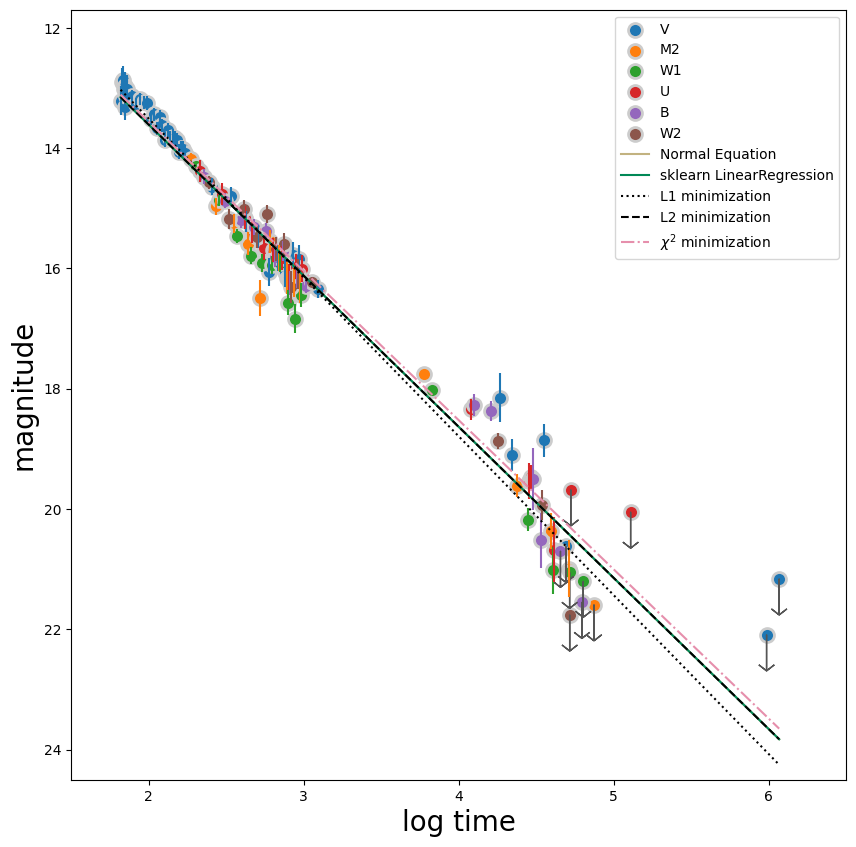

In [15]:
def plotline(pars, x, color='k', symbol='-', label='model',
             alpha=1, ax=ax):
    slope, intercept = pars
    y = line(intercept, slope, x)
    ax.plot(x, y, ls=symbol, c=color, label=label, alpha=alpha)


ax = plotlogtime(grbAG)
#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]
#normal equation
plotline((theta_best[::-1]), grbAG.logtime.values,
         color='#'+colors[0],
         label="Normal Equation", ax=ax)

#sklearn
plotline((lr.coef_[1], lr.intercept_), grbAG.logtime,
         color='#'+colors[2], symbol='-',
         label="sklearn LinearRegression", ax=ax)

#minimize L1
plotline((l1Solution.x[::-1]), grbAG.logtime,
         symbol=':',
         label="L1 minimization", ax=ax)
#minimize L2
plotline((l2Solution.x[::-1]), grbAG.logtime,
         symbol='--',
         label="L2 minimization", ax=ax)
#minimize chi2
plotline((chi2Solution.x[::-1]), grbAG.logtime,
         color='#'+colors[3], symbol='-.',
         label=r"$\chi^2$ minimization", ax=ax)

pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')

pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);


Figure 3: Same as Figure 1, but with linear regression models plotted. The models correspond to the best fit line to the data (excluding upper limits) calculated analytically by solving the normal equation, by solving the fit analysitcally with sklearn.LinearRegression(), and by minimizing the objective functions L1 and Chi squared. The models are indicated in the legend.

# HW part 1: redo the sklearn model with a train-test split of the data

- choose the train-test rations that you prefer
- get the score for the model when predicting on the train data and on the test data
- what can you say about the model by comparing the two scores?

In [16]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test  = train_test_split(X, y, test_size=0.25, random_state=42)

In [17]:
reg = LinearRegression()

reg.fit(X,y)
reg.score(x_train, y_train)

0.9715687013252898

In [18]:
reg.score(x_test,y_test)

0.9708464773733754

### Comparing the two scores

Between the training and test data, the model's score barely dropped. This score tells us how well the model is performing. The extremely small drop between the training and test data shows that the model hasn't been overfit to the training data subset, and can actually fit the general trends seen in data overall.

# Now try a line to the data with MCMC

# HW part 2: write captions for each figure. The figures are produced by my code. The captions should state:
- what is plotted
- what is noticeable or interesting in the figure



In [19]:
!pip install emcee # install the emcee package that implements the _affine invariant MCMC_ method

In [20]:
import emcee #import the package

In [21]:
emcee

<module 'emcee' from '/usr/local/lib/python3.10/dist-packages/emcee/__init__.py'>

look at documentation: https://emcee.readthedocs.io/en/stable/

We are implementing Bayes theorem to find the best model parameters: $P(\theta | D) ~ P(D | \theta) * P(\theta)$ or _Posterior ~ Likelihood * Prior_

Since we are maximizing the likelihood, we work in log space because:
- the logarithm is a monotonic function of its argument (meaning where the argument gets bigger its log gets bigger, where it gets smaller its log gets smaller)
- the log is not defined for negative values (log(something < 0) is undefined) but this does not matter because the likelihood is a probability and probabilities are positive defined.



In [22]:
# LINE MODEL
def log_prior(theta):
  slope, intercept = theta
  if slope > 0 and intercept > 0:
    return 0
  #semi informative prior: i know light has to get fainter (mag get bigger)
  #i know i dont use negative mags
  return -np.inf


In [23]:
#log likelihood
def log_likelihood(theta, x, y, yerr):
  slope, intercept = theta
  #chi2 likelihood : (data-model)**2 / uncertainty **2
  return -np.sum(((y - line(intercept, slope, x))**2) / yerr**2)

In [24]:
#log posterior
def log_posterior(theta, x, y, yerr):
  lp = log_prior(theta)
  if not np.isfinite(lp):
    return -np.inf
  # posterior ~ likelihood * prior => log_posterior ~ log_likelihood + log_prior
  return lp + log_likelihood(theta, x, y, yerr)

In [25]:
#initial guess
ig = [1,10]

In [26]:
#initialize N walkers
nwalkers = 32
ndim = len(ig)

In [27]:
pos = np.array(ig) + 1e-4 * np.random.randn(nwalkers, ndim) #the starting point for each walker is a small perturbation of the initial guess

In [28]:
pos.shape

(32, 2)

In [29]:
# this sets up the model and assignes the hyperparameters
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x, y, s))

In [30]:
# this runs the MCMC for 5,000 steps
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:14<00:00, 347.29it/s]


In [31]:
# this extracts the ergodic markovian chains of positions in the feature space
samples = sampler.get_chain()

In [32]:
samples.shape

(5000, 32, 2)

In [33]:
# to get statistical properties of the chains I will concatenate the 32 chains. This works _iff_ the chains are independent
# note: the chains are _assumed_ to be independent
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

In [34]:
#the result of the mcmc (the best parameters and their uncertainties) are statistical properties of the chains
# I recommand the median and percentiles over the mean and standard deviation, since the chains need not be gaussian
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
  mcmc[i] = np.percentile( flat_samples[:,i], [16, 50, 84])
mcmc

array([[2.46639205, 2.48042055, 2.49457393],
       [8.55969196, 8.59842934, 8.637372  ]])

In [35]:
!pip install corner

In [36]:
import corner

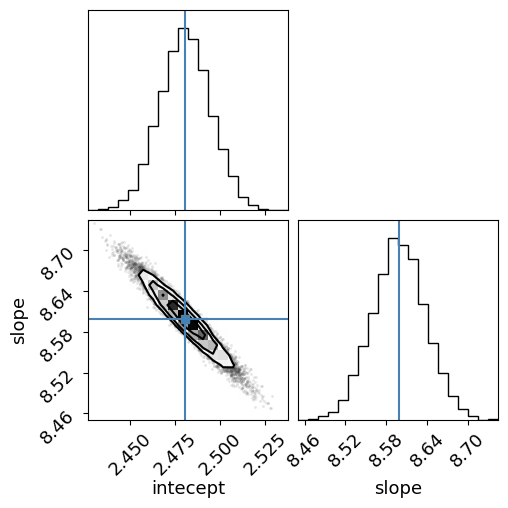

In [37]:
#plotting the likelihood space: the panels are 2D projections of the feature space and 1D marginalized probabilities for each parameters
pl.rcParams["font.size"]= 13
fig = corner.corner(
    flat_samples, labels=["intecept", "slope"], truths=mcmc[:,1]);


### Figure 4
Plotting a 2D projection of the parameter space of slope and intercept. The upper plot shows only the intercept likelihood and the rightmost plot shows only the slope likelihood.

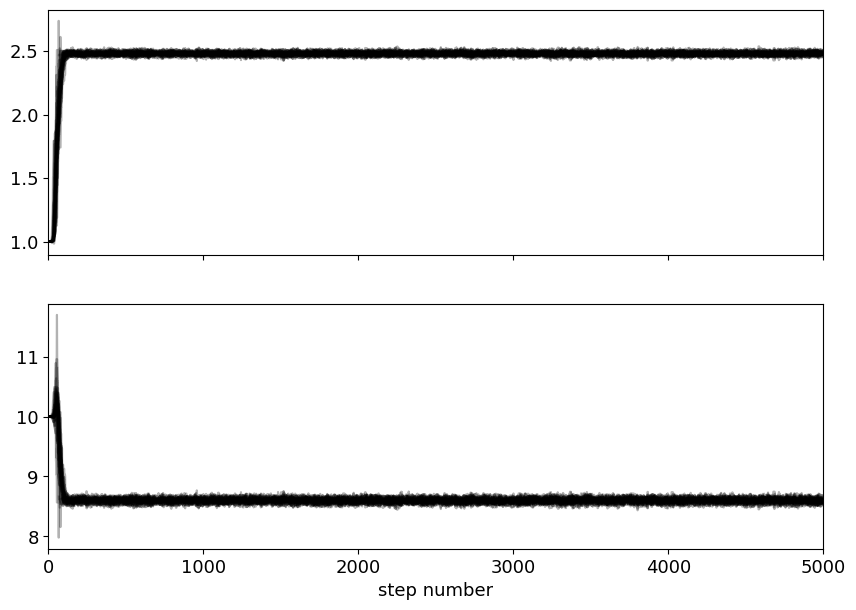

In [38]:
# the chains should be plotted as well. in the slides and in class I discuss what you should expect them to look like
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

### Figure 5
Plotting all the MCMC chains for their entire duration of steps. These plots show that after the first 100 to 200 steps, all of the chains have settled into a similar region of the parameter space.

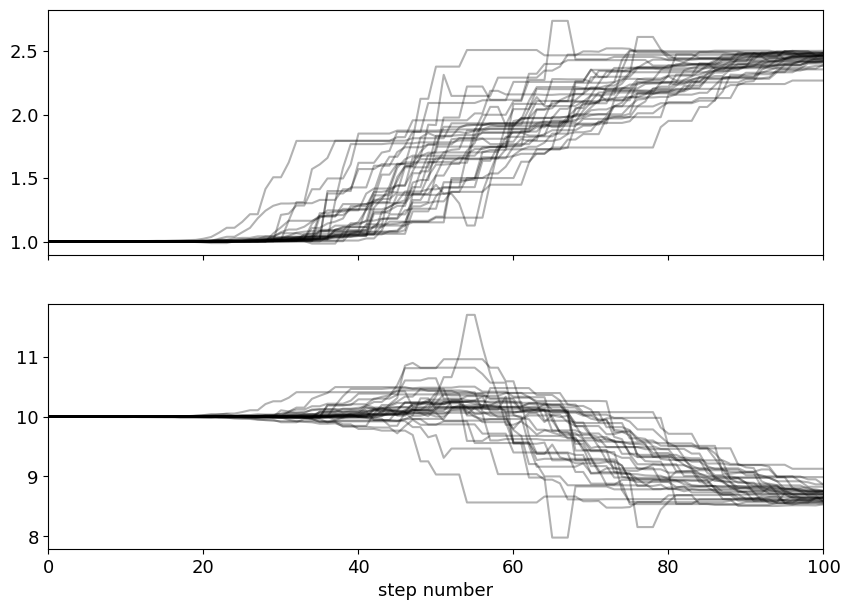

In [39]:
# zoom in: the beginnign of the chane should be cut - this is the burn-in part of the chain
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, 100)#len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

### Figure 6
Zooming in to the first 100 steps taken in each chain. Shows how the chains take several steps until they begin separating, and then don't combine beck until the region around 100 steps.

In [40]:
# save the mcmc results for later
mcmc_line = mcmc

# HW part 3

# Now try a broken power law (BPL) model

A power la is not a good model for GRB afterglows. A broken power law has been known to be a better model and has several physical motivations. In this exercise you will fit a _broke power law_ to the data, which is a more complex and higher dimensional model than the simple line fit we did so far, with MCMC getting best values for the posterior, a complete characterization of the likelihood, and allowing model selection between the line and the power law.

> Here is some info that talks about the power law model and the phsyics of GRB, which you need not know to solve the assignment but you may be interested in.  A broken power law is a power law ($y ~ x^a$) where the power a changes at some point. This can be caused by the presence of two power law processes with different, for example, where one dominates at early time and the other at late times.


>> Here is some more info that explains why we observed the GRB afterglows as broken power laws.
>>Gamma-ray bursts (GRBs) are produced by the collapse of massive stars or the merger of compact objects like neutron stars. The energy of the collapse is highly energetic (Gamma rays) but the emission gets reprocessed as it leaves the system and looses energy becoming detectable in the optical wavelengths. This is called the "optical afterglow of the GRB".
>>The explosion resulting from the collapse generates a highly relativistic outflow of material that moves at a significant fraction of the speed of light.
>> The afterglow emission is primarily produced through synchrotron radiation, where charged particles spiral around magnetic field lines. The radiation produced by synchrotrone follows a power law with an index that depends on the density of the surrounding medium, the Lorentz factor of the outflow, and the magnetic field strength. As the radiation crosses different regions of the system that collapsed these factors change and the powerlaw index changes with them.

>>If the relativistic outflow is highly collimated (a jet) as the jet expands, its emission can be modeled as a power-law light curve, but  where the jet begins to decelerate and spread out the slope of the power law changes. This transition is known as the "jet break" and results in a broken power-law behavior.

>> Some GRBs exhibit late-time flares or additional energy injection from the central engine but we are not modeling this in this exercise.




_BPL model variables:_

$F = \mathrm{flux}$ - note: not magnitude this time! $mag ~ -2.5log10(Flux)$

$t =  \mathrm{time}$ - note: not log time

_BPL model parameters:_


$T_b =  \mathrm{Time~of~break}$

$a_1:  \mathrm{Early~slope}$

$a_2: \mathrm{Late~slope}$

$b:  \mathrm{nuisance~parameters}$

_BPL model_:

$F=\frac{F_0}{ \frac{t}{T_b}^{-a1} + \frac{t}{T_b}^{-a2}}$


$b - log_{10}((\frac{t}{T_b})^{-a1} + (\frac{t}{T_b})^{-a2}) $



In [41]:
t = grbAG[grbAG.upperlimit == 0].time.values

In [42]:
t.min(), t.max()

(66, 51257)

In [43]:
x.max()

4.709753183947856

# HW part 3 task 1:
create the model `bpl()`, the `log_likelihood()`, `log_prior()` (choose what you want to set your prior to), and `log_posterior()`

In [44]:
def bpl(theta, x):
    """broken power law model
    Input:
      theta: (array like) 4 parameters vector, see equation
      x: (array like) independent variable
    Return:
      model predictions for each x (array like)
    """
    T_b, a_1, a_2, b = theta
    return b - np.log10((x/T_b)**(-a_1) +  (x/T_b)**(-a_2))



In [45]:
def log_prior_bpl(args):
  T_b, a_1, a_2, b = args
  if T_b > 0 and a_1 > 0 and a_2 > 0:
    return 0

  return -np.inf

def log_likelihood_bpl(theta, x, y, yerr):
    # use the same log_likelihood as before (chi2) but with the new model
    T_b, a_1, a_2, b = theta
    model = bpl(theta, x)
    return np.sum((y - model)**2 / yerr**2)

def log_posterior_bpl(theta, x, y, yerr):
  lp = log_prior_bpl(theta)
  if not np.isfinite(lp):
    return -np.inf
  ll = log_likelihood_bpl(theta, x, y, yerr)

  # posterior ~ likelihood * prior => log_posterior ~ log_likelihood + log_prior
  return lp - ll

# HW part 3 task 2:
Find the initial starting point as a stochastic gradient descent minimization of the log likelihood

In [46]:
ig2 = [1000, 5, 20, 0.2]
#what does the minimize function need to take as arguments?
soln = minimize(log_likelihood_bpl, ig2, args = (t, y, s)) #s is yerr
soln

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 217.46531456855303
        x: [ 2.736e+02  3.548e+00  2.146e+00  1.505e+01]
      nit: 79
      jac: [ 1.526e-05 -3.624e-05 -3.052e-05  4.005e-05]
 hess_inv: [[ 1.477e-03 -2.157e-03  5.454e-04 -2.955e-04]
            [-2.157e-03  3.228e-03 -8.951e-04  4.756e-04]
            [ 5.454e-04 -8.951e-04  3.279e-04 -1.552e-04]
            [-2.955e-04  4.756e-04 -1.552e-04  1.728e-04]]
     nfev: 699
     njev: 138

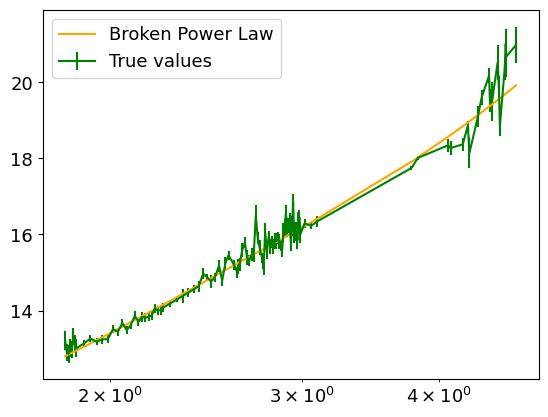

In [47]:
ig = soln.x # the initial guess for the MCMC

# plot the model as it looks with the initial guess values
pl.errorbar(x, y, yerr=s, color = "green", label = 'True values')
pl.plot(x, bpl(ig, t), color = "orange", label = 'Broken Power Law')
pl.xscale("log")
pl.legend()
pl.show()

###Figure 7
This plot shows the broken power law fit over top of the actual data points. Highlights that the bpl is a pretty good fit to the actual data.

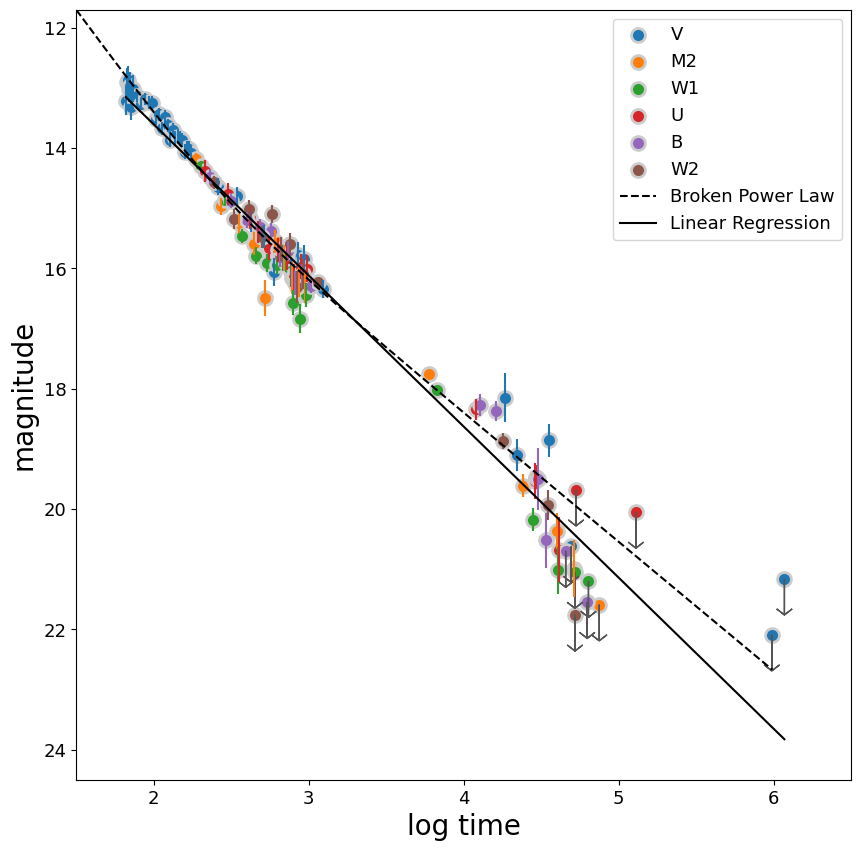

In [48]:
labels = ["intercept","slope"]
ax = plotlogtime(grbAG)
#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]

ax.plot(np.arange(1.5,6,0.01),bpl(ig, 10**np.arange(1.5,6,0.01)), ls="--", c="k",label="Broken Power Law")



#with the LinearRegression object I can also do
pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-', label = 'Linear Regression')

pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20)
pl.legend();

###Figure 8
Plot of magnitude versus log time showing the true data values. Also shows the broken power law best fit line and the linear regression best fit. Both are pretty good fits to the data, though the broken power law seems to have captured the change between the two groupings of data better.

# HW 3 task 3: optimize the model wit MCMC

- set the emcee hyperparameters
- run the chains
- extract the statistical properties of the chain as the best fit values
- plot the model
- plot the marginalized posteriors of the model parameters

In [49]:
# set the emcee hyperparameters
pos = np.array(ig) + 1e-4*np.random.randn(32, len(ig))

nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_bpl, args=(t, y, s))

In [50]:
sampler.run_mcmc(pos, 5000, progress = True)

100%|██████████| 5000/5000 [00:26<00:00, 189.08it/s]


State([[285.08981065   3.4811023    2.17370318  15.09669665]
 [343.19388934   3.47080245   2.09302675  15.3174592 ]
 [280.29704069   3.57818139   2.1069419   15.10776107]
 [238.11174874   3.5925226    2.15580066  14.88615853]
 [275.86098127   3.4554204    2.18038608  15.03530529]
 [294.07315213   3.43169792   2.14162838  15.11153127]
 [261.72090705   3.50544198   2.16848198  14.95572254]
 [403.5277831    3.42801947   2.05568583  15.53125365]
 [346.33542212   3.38976094   2.12041769  15.31813962]
 [200.40116054   3.64938563   2.19957414  14.66240935]
 [345.04800464   3.41533644   2.09926182  15.307803  ]
 [238.3167559    3.7200537    2.14150313  14.89902315]
 [265.2214039    3.56948078   2.15628052  15.01725134]
 [194.79781485   3.87973411   2.18984179  14.64966848]
 [319.04672862   3.49918088   2.09376941  15.24516644]
 [315.2700742    3.48859921   2.14381825  15.23421797]
 [274.90360467   3.50102116   2.14951924  15.04082968]
 [351.06043535   3.38311081   2.11087182  15.34227001]
 [31

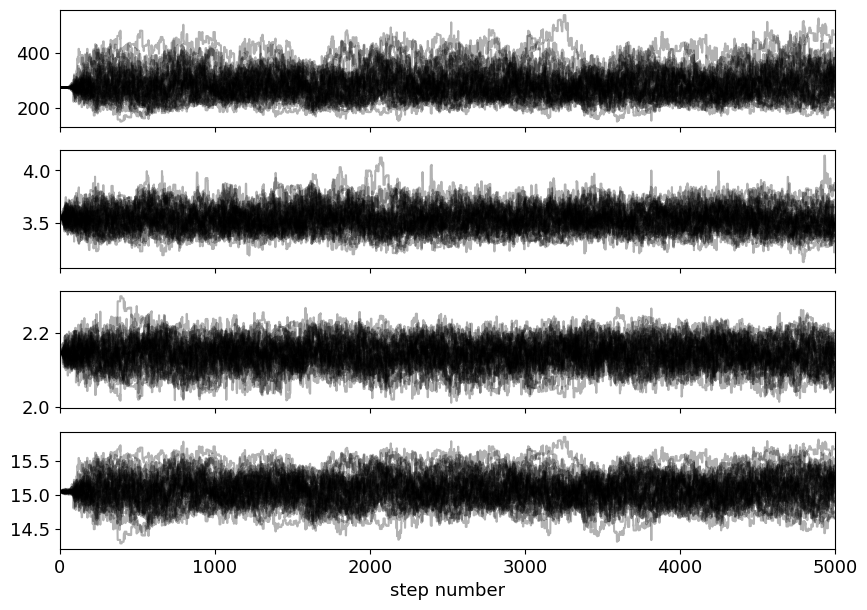

In [61]:
#plot the chains
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");

###Figure 9
Plot showing the MCMC chains for the four different parameters needed in the broken power law. These plots don't settle down as much as the linear fit mcmc chains plotted earlier. Though outside of T_b, the actual spread in the parameters seen by the chains is around 1 or less.

In [52]:
# get the 16th, 50, and 84th percentiles of the model parameters
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
    mcmc[i] = np.percentile(flat_samples[:,i], [16,50,84])
mcmc[:,1]

array([279.06296865,   3.53351724,   2.14384651,  15.06988468])

In [53]:
!pip install corner

In [54]:
import corner

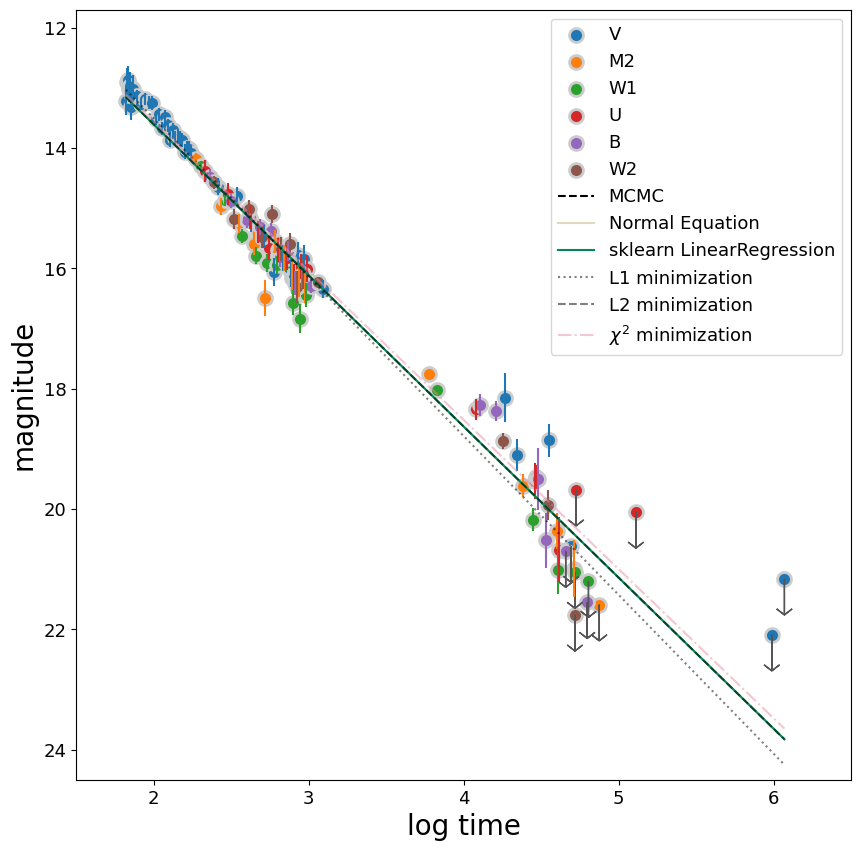

In [55]:
#plot the model
ax = plotlogtime(grbAG)

#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]

ax.plot(grbAG.logtime.values, line(mcmc[:,1][0], mcmc[:,1][1],
                            grbAG.logtime.values), ls="--", c="k", label="MCMC")
#normal equation
plotline((theta_best[::-1]), grbAG.logtime.values,
         color='#'+colors[0],  alpha=0.5,
         label="Normal Equation", ax=ax)
#sklearn
plotline((lr.coef_[1], lr.intercept_), grbAG.logtime,
         color='#'+colors[2], symbol='-',
         label="sklearn LinearRegression", ax=ax)
#minimize L1
plotline((l1Solution.x[::-1]), grbAG.logtime,
         symbol=':', alpha=0.5,
         label="L1 minimization", ax=ax)
#minimize L2
plotline((l2Solution.x[::-1]), grbAG.logtime,
         symbol='--', alpha=0.5,
         label="L2 minimization", ax=ax)
#minimize chi2
plotline((chi2Solution.x[::-1]), grbAG.logtime,
         color='#'+colors[3], symbol='-.', alpha=0.5,
         label=r"$\chi^2$ minimization", ax=ax)

pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')
pl.axvline(np.log10(mcmc[2,1]))
pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);

###Figure 10
Plot of magnitude versus log time of the actual data points, as well as all of the best fits that have been calculated in this notebook. All of these fits are pretty good, with the MCMC and sklearn fits being the best for the magnitude clump at the higher log times.

## plot the marginalized posterior distributions of the parameters

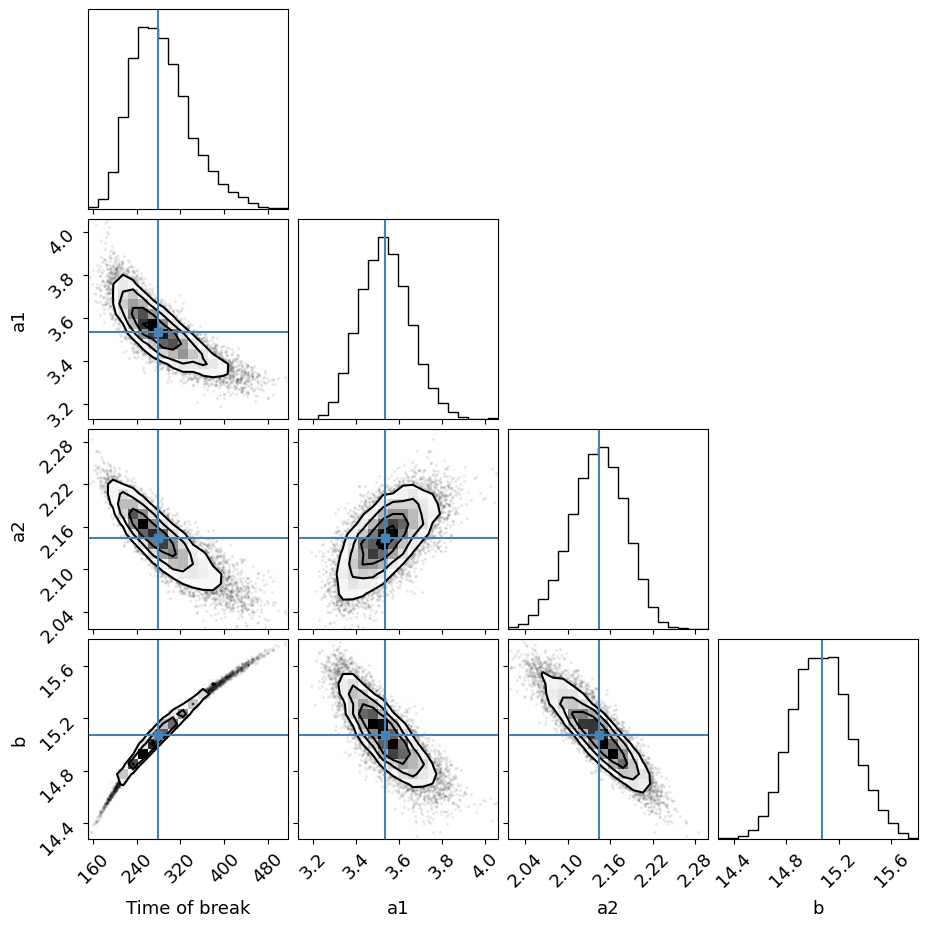

In [56]:
pl.rcParams["font.size"]= 13
fig = corner.corner(flat_samples, labels = ['Time of break', 'a1', 'a2', 'b'], truths=mcmc[:,1]);

###Figure 11
Plot showing all the 2-dimensional parameter spaces for T_b, a1, a2, and b for the broken power law. The spreads for a1, a2, and b are very small and following a Gaussian-like distribution, which is seen in the top plot in each column. The spread for T_b seems to be follwing a combined Gaussian and exponential decay function, or is a Gaussian spread on top of a exponential decay.

# HW part 4: Compare the line (as obtained by the MCMC) and broken power law models. For this part of the assignment use the slides in part 2.2 of the current slide deck (slide column 8) https://slides.com/federicabianco/dsps_6#/8. in particular:

- Print the loglikelihood of each model (you can use the log_likelihood function you had written for each)
https://slides.com/federicabianco/dsps_6#/8/1 through https://slides.com/federicabianco/dsps_6#/8/3

- implement the caluculation of the AIC (https://slides.com/federicabianco/dsps_6#/8/4 through 6)
- and BIC (https://slides.com/federicabianco/dsps_6#/8/7)



In [57]:
print("The log likelihood of the linear fit is "+'{:.2f}'.format(log_likelihood(mcmc_line[:,1], x, y, s))) #control the decimal digits!

The log likelihood of the linear fit is -317.42


In [58]:
print("The log likelihood of the broken power law fit is "+'{:.2f}'.format(log_likelihood_bpl(mcmc[:,1], t, y, s)))

The log likelihood of the broken power law fit is 217.48


## Implement the likelihood ration test printing out the likelihood ration statistics

The likelihood-ratio test assesses the goodness of fit of two competing _nested_ statistical models based on the values of the likelihood $L$ where $M1$ is the restricted model (the parameter space is smaller, hence restricted), nested inside $M2$, the full model (the more complex one).

$ \lambda_\mathrm{LR}=-2\ln {\frac {L(M1(\theta_\mathrm{restricted}))}{L(M2(\theta_\mathrm{full}))}}$

This statistics is expected to be $\chi2$ distributed following a $ch2$ distribution with d.o.f=difference in size of the parameter space in the two models (number of parameters in bpl model - number of parameters in line model).


In [59]:
def like_ratio_statistics(...):
  return ...

SyntaxError: ignored

## Calculate the AIC and BIC: Aikiki Information Criterion and Bayesian Information Criterion for the comparison of the same two models.


In [62]:
def aic(x, l, k):
  return 2 / len(x) * (l + k)


def bic(x, l, k):
  return 2 * l + np.log(len(x)) * k


In [63]:
print("AIC line {0:.2f} - AIC bpl {1:.2f}".format(aic(x, log_likelihood(mcmc_line[:,1], x, y, s), 2),
                                      aic(x, log_likelihood_bpl(mcmc[:,1], t, y, s), 4)))

print("BIC line {0:.2f} - BIC bpl {0:.2f}".format(bic(x, log_likelihood(mcmc_line[:,1], x, y, s), 2),
                                      bic(x, log_likelihood_bpl(mcmc[:,1], t, y, s), 4)))

AIC line -5.84 - AIC bpl 4.10
BIC line -625.48 - BIC bpl -625.48


# Extra Credit
 redefine the chi2 that I have written above to take a n deg polynomial, fit it to the data, compare it to the BPL model